In [14]:
import warnings
import numpy as np
import pandas as pd
import random
import os
import torch
import json
import python_avatars as pa
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score,
    adjusted_rand_score,
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

from langchain import PromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("API_KEY")

if not API_KEY:
    raise ValueError("Missing OPENAI_API_KEY in .env file")

genai.configure(api_key=os.environ["API_KEY"])
model = genai.GenerativeModel('gemini-1.5-flash',
                              generation_config={"response_mime_type": "application/json"})


In [ ]:
pip install -U scikit-fuzzy python_avatars

Note: you may need to restart the kernel to use updated packages.


In [15]:
def clean_data(dframe, is_labeled=True):
    """
    Cleans the DataFrame by handling missing values, dropping columns with constant values,
    and label encoding categorical columns.

    Parameters:
    - dframe: Original DataFrame
    - is_labeled: Boolean indicating whether the DataFrame is labeled or unlabeled

    Returns:
    - Cleaned DataFrame
    """
    df = dframe.copy()

    # Fill missing values with mean for numeric columns
    for column in df.columns:
        if df[column].dtype != object:
            df[column] = df[column].fillna(df[column].mean())

    # Drop columns with constant values
    columns_to_drop = [col for col in df.columns if len(df[col].unique()) == 1]
    df.drop(columns=columns_to_drop, inplace=True)

    # Label encode text label columns
    for column_name in df.columns:
        if df[column_name].dtype == object:
            df[column_name] = LabelEncoder().fit_transform(df[column_name])

    # Check if the last column is label encoded or not
    if is_labeled and (df.iloc[:, -1].dtype == object or df.iloc[:, -1].dtype == bool):
        print("Last column is not label encoded. Label encoding it now...")
        df.iloc[:, -1] = LabelEncoder().fit_transform(df.iloc[:, -1])

    return df

def normalize_columns(df, list_of_columns, is_labeled=True):
    """
    Normalizes specified columns using StandardScaler.

    Parameters:
    - df: Original DataFrame
    - list_of_columns: List of columns to normalize

    Returns:
    - DataFrame with normalized columns
    """
    dframe = df.copy()
    if len(list_of_columns) > 0:
        # If the dataset is labeled and the last column is not to be normalized
        if is_labeled:
            last_column = dframe.columns[-1]
            list_of_columns = [col for col in list_of_columns if col != last_column]

            # Normalize the specified columns
        for column_name in list_of_columns:
            dframe[column_name] = StandardScaler().fit_transform(dframe[column_name].values.reshape(-1, 1))

    return dframe

def feature_selection_variance_threshold(df, t_value, is_labeled=True):
    """
    Perform feature selection using VarianceThreshold.

    Parameters:
    - df: Original DataFrame
    - t_value: Threshold value for variance

    Returns:
    - DataFrame with selected features
    """
    dframe = df.copy()
    selector = VarianceThreshold(threshold=t_value)
    # Separate the target variable (last column)
    if is_labeled:
        target_column = df.columns[-1]
        X = df.drop(columns=[target_column])
        y = df[target_column]
        # Create a VarianceThreshold selector
        # Fit the selector to the features
        X_selected = selector.fit_transform(X)
        # Get the indices of the selected features
        features_to_keep = selector.get_support(indices=True)
        # Select the features using the indices
        selected_features = X.iloc[:, features_to_keep]
        # Concatenate the selected features with the target column
        result_df = pd.concat([selected_features, y], axis=1)
        return result_df
    else:
        selector.fit(dframe)
        features_to_keep = selector.get_support(indices=True)
        return dframe.iloc[:,features_to_keep]

def feature_selection_k_best(df, k_value, is_labeled=True):
    """
    Perform feature selection using SelectKBest with mutual_info_classif.

    Parameters:
    - df: Original DataFrame
    - k_value: Number of top features to select

    Returns:
    - DataFrame with selected features
    """
    if is_labeled:
    # Separate the target variable (last column)
        target_column = df.columns[-1]
        X = df.drop(columns=[target_column])
        y = df[target_column]
    else:
        X = df.copy()
        y = np.zeros(df.shape[0])

    # Create a SelectKBest selector
    selector = SelectKBest(score_func=mutual_info_classif, k=k_value)

    # Fit the selector to the features
    X_selected = selector.fit_transform(X, y)

    # Get the indices of the selected features
    features_to_keep = selector.get_support(indices=True)

    # Select the features using the indices
    selected_features = X.iloc[:, features_to_keep]

    if is_labeled:
        # Concatenate the selected features with the target column
        result_df = pd.concat([selected_features, y], axis=1)
        return result_df
    else:
        selected_feature_names = X.columns[features_to_keep]
    return X[selected_feature_names]

def plot_pairplot(df, cols_plot_info, hue_column):
    sns.pairplot(data=df[cols_plot_info], hue=hue_column, palette=["#3EC1D3", "#FFD36E"], corner=True)
    plt.show()

In [24]:
def cluster_kmeans_gpu(original_data, df, gpu_indx=0):
    """
    Perform K-Means clustering on the given DataFrame for a range of K values.
    Output optimal K values based on GridSearchCV.

    Parameters:
    - original_data: Original DataFrame to add clustering labels to.
    - df: DataFrame for clustering.
    - gpu_indx: Index of the GPU to use (default is 0).

    Returns:
    - None
    """
    # Select device
    device = torch.device(f'cuda:{gpu_indx}' if torch.cuda.is_available() else 'cpu')
    
    # Convert DataFrame to PyTorch tensor and move to selected device
    data_tensor = torch.tensor(df.values, dtype=torch.float32).to(device)

    # Hyperparameter tuning using GridSearchCV
    kmeans = KMeans()
    param_grid = {
        'n_clusters': [2, 3, 4, 5],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 300, 500],
        'random_state': [0, 50]
    }
    grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV using CPU
    grid_search.fit(X=df.values[:, :-1], y=df.values[:, -1])
    best_params = grid_search.best_params_

    # Fit K-Means clustering with the optimal hyperparameters
    kmeans = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], 
                    max_iter=best_params['max_iter'], random_state=best_params['random_state'])
    kmeans.fit(df.values)

    clustered_df = df.copy()
    cluster_prediction = kmeans.predict(df.values)
    clustered_df["label"] = cluster_prediction
    original_data["label"] = cluster_prediction

    label_mapping = {i: chr(65 + i) for i in range(kmeans.n_clusters)}
    clustered_df['label'] = clustered_df['label'].replace(label_mapping)
    clustered_df.to_csv('../data/labeled_result_kmeans.csv', index=False)

In [29]:
def visualize_dendrogram(df):
    """
    Visualize dendrogram for hierarchical clustering and save to ./static/ folder.
    """
    linkage_matrix = linkage(df, method='ward', metric='euclidean')

    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, p=5, truncate_mode='level', orientation='top', show_leaf_counts=True, above_threshold_color='y')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index or Cluster Size')
    plt.ylabel('Distance')
    plt.savefig('./static/hierarchical_clustering_dendrogram.png')
    plt.close()

def visualize_clusters(df, labels):
    """
    Visualize scatter plot for cluster and save to ./static/ folder.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df.iloc[:, 3], y=df.iloc[:, 7], hue=labels, palette=["#3EC1D3", "#FFD36E"], s=100)
    plt.title('Agglomerative Clustering')
    plt.savefig('./static/agglomerative_clustering.png')
    plt.close()

def cluster_agglomerative(df, k_values=2):
    """
    Perform Agglomerative clustering on the given DataFrame for a range of K values.
    Output optimal K values based on various metrics.

    Parameters:
    - df: DataFrame for clustering
    - k_values: Maximum number of clusters to consider

    Returns:
    - Dictionary with optimal K values and metrics
    """
    dframe = df.copy()
    k_values = range(2, k_values)

    visualize_dendrogram(dframe)

    # Hyperparameter tuning using GridSearchCV
    agg_clustering = AgglomerativeClustering()
    param_grid = {
        'n_clusters': k_values,
        'linkage': ['ward', 'complete', 'average'],
    }
    grid_search = GridSearchCV(estimator=agg_clustering, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(dframe)

    best_params = grid_search.best_params_

    silhouette_scores, dbi_scores, ch_indices, ami_scores, fm_scores, ar_scores, dunn_indices = [], [], [], [], [], [], []

    true_labels = dframe.pop(dframe.columns[-1])
    
    for k in k_values:
        agg = AgglomerativeClustering(n_clusters=k, linkage=best_params['linkage'])
        agg.fit(dframe)

        clustered_dframe = dframe.copy()
        cluster_prediction = agg.fit_predict(clustered_dframe)
        clustered_dframe["label"] = cluster_prediction

        label_mapping = {i: chr(65 + i) for i in range(agg.n_clusters)}
        clustered_dframe['label'] = clustered_dframe['label'].replace(label_mapping)

        silhouette_scores.append(silhouette_score(dframe, agg.labels_))
        dbi_scores.append(davies_bouldin_score(dframe, agg.labels_))
        ch_indices.append(calinski_harabasz_score(dframe, agg.labels_))
        predicted_labels = agg.labels_
        ami_scores.append(adjusted_mutual_info_score(true_labels, predicted_labels))
        fm_scores.append(fowlkes_mallows_score(true_labels, predicted_labels))
        ar_scores.append(adjusted_rand_score(true_labels, predicted_labels))

        if k == best_params['n_clusters']:
            clustered_dframe.to_csv('./static/labeled_result_agglomerative.csv', index=False)

    optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
    optimal_k_dbi = k_values[np.argmin(dbi_scores)]
    optimal_k_ch = k_values[np.argmax(ch_indices)]
    optimal_ami = k_values[np.argmax(ami_scores)]
    optimal_fm = k_values[np.argmax(fm_scores)]
    optimal_ar = k_values[np.argmax(ar_scores)]

    agg_optimal = AgglomerativeClustering(n_clusters=optimal_k_silhouette, linkage=best_params['linkage'])
    optimal_labels = agg_optimal.fit_predict(dframe)
    visualize_clusters(dframe, optimal_labels)
    points_in_each_cluster = pd.Series(optimal_labels).value_counts().sort_index().reset_index()
    points_in_each_cluster.columns = ['Cluster', 'Count']
    
    dunn_indices = []
    df2 = dframe.astype(np.float32)

    for k in k_values:
        agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
        agg.fit(dframe)

        distances = pairwise_distances(df2)
        min_inter_cluster_distance = np.inf
        for i in range(k):
            for j in range(i + 1, k):
                inter_cluster_distance = np.min(distances[np.where(agg.labels_ == i)][:, np.where(agg.labels_ == j)])
                min_inter_cluster_distance = min(min_inter_cluster_distance, inter_cluster_distance)

        max_intra_cluster_diameter = max([np.max(distances[np.where(agg.labels_ == i)]) for i in range(k)])
        dunn_index = min_inter_cluster_distance / max_intra_cluster_diameter
        dunn_indices.append(dunn_index)

    optimal_k = k_values[np.argmax(dunn_indices)]
    optimal_k_list = [optimal_k_silhouette, optimal_k_dbi, optimal_k_ch, optimal_ami, optimal_fm, optimal_ar, optimal_k]

    result = {
        "Best Hyperparameters": best_params,
        "Optimal K from Silhouette Score": (optimal_k_silhouette, max(silhouette_scores)),
        "Optimal K from Davies Bouldin Index": (optimal_k_dbi, min(dbi_scores)),
        "Optimal K from Calinski Harabasz Index": (optimal_k_ch, max(ch_indices)),
        "Optimal K from Adjusted Mutual Info": (optimal_ami, max(ami_scores)),
        "Optimal K from Fowlkes Mallows Score": (optimal_fm, max(fm_scores)),
        "Optimal K from Adjusted Rand Score": (optimal_ar, max(ar_scores)),
        "Dunn Index values for different K values": dunn_indices,
        "Optimal K based on Dunn Index": optimal_k,
        "Points in each cluster": points_in_each_cluster
    }

    return result

In [30]:
def cluster_dbscan(df, eps_value=0.5):
    """
    Perform DBSCAN clustering on the given DataFrame for a range of epsilon and min_samples values.
    Output optimal parameters based on various metrics.

    Parameters:
    - df: DataFrame for clustering
    - eps_values: List of epsilon values to consider
    - min_samples_values: List of min_samples values to consider

    Returns:
    - Dictionary with optimal parameters and metrics
    """
    dframe = df.copy()
    
    dbscan = DBSCAN()

    param_grid = {
        'eps': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        'min_samples': [5, 10, 15, 20],
        'metric': ['euclidean'],
    }

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(estimator=dbscan, param_grid=param_grid, cv=5, scoring=silhouette_score)
    grid_search.fit(dframe)
    
    best_params = grid_search.best_params_

    # Extract true labels for evaluation
    true_labels = dframe.pop(dframe.columns[-1])

    # Initialize lists to store evaluation metrics
    silhouette_scores, dbi_scores, ch_indices, ami_scores, fm_scores, ar_scores = [], [], [], [], [], []

    # Iterate over different values of epsilon
    for epsilon in param_grid['eps']:
        # Fit DBSCAN with the current epsilon value
        dbscan = DBSCAN(eps=epsilon, min_samples=best_params['min_samples'], metric=best_params['metric'])
        dbscan.fit(dframe)
        labels = set(dbscan.labels_)

        clustered_dframe = dframe.copy()
        cluster_prediction = dbscan.fit_predict(dframe)
        clustered_dframe["label"] = cluster_prediction

        unique_labels = np.unique(cluster_prediction)
        label_mapping = {label: chr(65 + idx) if label != -1 else 'Noise' for idx, label in enumerate(unique_labels)}
        clustered_dframe['label'] = clustered_dframe['label'].map(label_mapping)

        # Visualize cluster assignments for optimal epsilon
        if epsilon == best_params['eps']:
            points_in_each_cluster = pd.Series(dbscan.labels_).value_counts().sort_index().reset_index()
            points_in_each_cluster.columns = ['Cluster', 'Count']
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=dframe.iloc[:, 3], y=dframe.iloc[:, 7], hue=dbscan.labels_, palette=["#3EC1D3", "#FFD36E"])
            plt.title(f'DBSCAN Clustering - Epsilon: {epsilon}')
            plt.savefig('./static/dbscan_clustering.png')
            plt.close()
            
            clustered_dframe.to_csv('./data/labeled_result_dbscan.csv', index=False)

        # Check if there is more than one cluster
        if len(labels) == 1:
            continue

        # Calculate evaluation metrics
        silhouette_avg = silhouette_score(dframe, dbscan.labels_)
        silhouette_scores.append(silhouette_avg)

        dbi = davies_bouldin_score(dframe, dbscan.labels_)
        dbi_scores.append(dbi)

        ch_score = calinski_harabasz_score(dframe, dbscan.labels_)
        ch_indices.append(ch_score)

        predicted_labels = dbscan.labels_

        ami = adjusted_mutual_info_score(true_labels, predicted_labels)
        ami_scores.append(ami)

        fm = fowlkes_mallows_score(true_labels, predicted_labels)
        fm_scores.append(fm)

        ar = adjusted_rand_score(true_labels, predicted_labels)
        ar_scores.append(ar)

    # Perform Dunn Index calculation
    dunn_indices = []
    df2 = dframe.astype(np.float32)

    for epsilon in param_grid['eps']:
        dbscan = DBSCAN(eps=epsilon, min_samples=best_params['min_samples'], metric=best_params['metric'])
        dbscan.fit(dframe)
        labels = set(dbscan.labels_)

        if len(labels) == 1:
            continue

        distances = pairwise_distances(df2)
        min_inter_cluster_distance = np.inf
        cluster_indices = np.unique(dbscan.labels_)

        for i in range(len(cluster_indices)):
            for j in range(i + 1, len(cluster_indices)):
                cluster_i_indices = np.where(dbscan.labels_ == cluster_indices[i])[0]
                cluster_j_indices = np.where(dbscan.labels_ == cluster_indices[j])[0]

                if len(cluster_i_indices) > 0 and len(cluster_j_indices) > 0:
                    inter_cluster_distance = np.min(distances[cluster_i_indices][:, cluster_j_indices])
                    min_inter_cluster_distance = min(min_inter_cluster_distance, inter_cluster_distance)

        max_intra_cluster_diameter = max([np.max(distances[np.where(dbscan.labels_ == i)]) for i in cluster_indices])

        dunn_index = min_inter_cluster_distance / max_intra_cluster_diameter
        dunn_indices.append(dunn_index)

    result = {
        "Best Hyperparameters": best_params,
        "Silhouette Scores": silhouette_scores,
        "Davies Bouldin Scores": dbi_scores,
        "Calinski Harabasz Scores": ch_indices,
        "Adjusted Mutual Info Scores": ami_scores,
        "Fowlkes Mallows Scores": fm_scores,
        "Adjusted Rand Scores": ar_scores,
        "Dunn Index values": dunn_indices,
    }

    if dunn_indices:
        optimal_k_dunn = param_grid['eps'][np.argmax(dunn_indices)]
        result["Optimal epsilon based on Dunn Index"] = optimal_k_dunn

    return result


In [40]:
def process_and_visualize_labeled_data(file_path, colors):
    """
    Process and visualize labeled data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file containing labeled data.
    - colors: List of colors for the plot.

    Returns:
    - df_res: DataFrame with group sizes.
    - df_plot: DataFrame sorted by label.
    - Plot saved as 'group_count_plot.png' in the './assets/' folder.
    """
    df = pd.read_csv(file_path)

    # Calculate group sizes
    df_res = round(df['label'].value_counts(normalize=True), 2).rename_axis('group').to_frame('group_size').sort_index()

    # Sort the data by labels
    df_plot = df.sort_values(by='label').reset_index(drop=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df_plot["label"], palette=colors)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel('Number of Customers in the Group', fontsize=12)
    plt.title('Customer Group Distribution')
    plt.savefig('../frontend/public/assets/group_count_plot.png')
    plt.close()

    return df_res, df_plot


In [12]:
def analyze_summary_dynamic(df, label_column='label', output_file='../data/summary_result_clustering_test.csv'):
    """
    Performs statistical analysis on all columns (except the label column) grouped by clusters.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_column (str): The column name for cluster labels. Default is 'label'.
        output_file (str): Path to save the summary CSV file. Default is '../data/summary_result_clustering_test.csv'.

    Returns:
        pd.DataFrame: A DataFrame containing the summary results.
    """
    
    # Exclude the label column from analysis
    cols_to_analyze = df.columns[df.columns != label_column]

    # Initialize the result DataFrame with group sizes
    df_res = round(df[label_column].value_counts(normalize=True), 2).rename_axis('group').to_frame('group_size').sort_index()

    # Calculate quartiles and ranks for each column based on its type
    for col in cols_to_analyze:
        if pd.api.types.is_numeric_dtype(df[col]):
            df_res[f"{col}_q1"] = df.groupby(label_column)[col].quantile(0.25).to_list()
            df_res[f"{col}_q3"] = df.groupby(label_column)[col].quantile(0.75).to_list()
            df_res[f"{col}_rank_q1"] = df_res[f"{col}_q1"].rank(method='max', ascending=False).astype(int).to_list()
            df_res[f"{col}_rank_q3"] = df_res[f"{col}_q3"].rank(method='max', ascending=False).astype(int).to_list()
        elif pd.api.types.is_bool_dtype(df[col]):
            df_res[f"{col}_mean"] = df.groupby(label_column)[col].mean().round(2).to_list()
        elif pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            # For categorical or object types, calculate mode (most frequent value)
            df_res[f"{col}_mode"] = df.groupby(label_column)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_list()

    # Save the result to a CSV file
    df_res.to_csv(output_file)

    return df_res

In [33]:
def generate_avatar(gender):
    female_hair_type = [pa.HairType.STRAIGHT_STRAND, pa.HairType.BOB, pa.HairType.LONG_NOT_TOO_LONG,
                        pa.HairType.BRIDE, pa.HairType.CURLY_2, pa.HairType.MIA_WALLACE,
                        pa.HairType.STRAIGHT_1, pa.HairType.STRAIGHT_2]
    male_hair_type = [pa.HairType.SHAGGY, pa.HairType.SHORT_FLAT, pa.HairType.CAESAR,
                      pa.HairType.CAESAR_SIDE_PART, pa.HairType.SHORT_WAVED, pa.HairType.POMPADOUR,
                      pa.HairType.ELVIS, pa.HairType.BUZZCUT]
    clothing_color = ["#E5CB93", "#A9DBEA", "#DBD2F4", "#FF8B71", "#878ECD", "#046582",
                      "#DAD8D7", "#DAD8D7", "#C0D8C0", "#DD4A48", "#FEA82F", "#FF6701"]
    clothing_style = [pa.ClothingType.SHIRT_SCOOP_NECK, pa.ClothingType.BLAZER_SWEATER,
                      pa.ClothingType.COLLAR_SWEATER, pa.ClothingType.HOODIE,
                      pa.ClothingType.SHIRT_CREW_NECK]
    hair_color = ["#6B3307", "#000000", "#C4942D", "#B05A08", "#3F4E4F", "#A27B5C",
                  "#A19882", "#555555", "#7F7C82", "#FEA82F"]

    if gender == 'Female':
        my_avatar = pa.Avatar(
            style=pa.AvatarStyle.CIRCLE,
            background_color="#F4F9F9",
            top=random.choice(female_hair_type),
            eyebrows=pa.EyebrowType.DEFAULT_NATURAL,
            eyes=pa.EyeType.DEFAULT,
            nose=pa.NoseType.DEFAULT,
            mouth=pa.MouthType.SMILE,
            facial_hair=pa.FacialHairType.NONE,
            skin_color="#FBD9BF",
            hair_color=random.choice(hair_color),
            accessory=pa.AccessoryType.NONE,
            clothing=random.choice(clothing_style),
            clothing_color=random.choice(clothing_color)
        )
    else:
        my_avatar = pa.Avatar(
            style=pa.AvatarStyle.CIRCLE,
            background_color="#F4F9F9",
            top=random.choice(male_hair_type),
            eyebrows=pa.EyebrowType.DEFAULT_NATURAL,
            eyes=pa.EyeType.DEFAULT,
            nose=pa.NoseType.DEFAULT,
            mouth=pa.MouthType.SMILE,
            facial_hair=pa.FacialHairType.NONE,
            skin_color="#FBD9BF",
            hair_color=random.choice(hair_color),
            accessory=pa.AccessoryType.NONE,
            clothing=random.choice(clothing_style),
            clothing_color=random.choice(clothing_color)
        )

    image_svg = my_avatar.render()
    image_svg = image_svg.replace("264px", "100%")
    image_svg = image_svg.replace("280px", "100%")

    return image_svg

In [31]:
def generate_persona(summary: dict) -> dict:
    """Generates a customer persona based on input summary.

    Args:
        summary (dict): Summary dictionary containing demographic, interest, and behavior information.

    Returns:
        dict: A dictionary containing the generated customer persona.
    """

    persona_schema = {
        "name": "response",
        "description": """{
            "cluster_summaries": [],
            "cluster_personas": []
        }"""
    }

    response_schema = [persona_schema]
    output_parser = StructuredOutputParser.from_response_schemas(response_schema)
    format_instructions = output_parser.get_format_instructions()

    prompt_template = """
    I want you to generate two things in valid JSON format:
    1. Generate a detailed cluster summary for each cluster group in a textual format based on the provided demographic, interest, and behavior information.
    2. Generate detailed customer persona for each cluster group defined by each row of summary provided in the format defined in the example (please give one value for demographic data and not ranges):

    IMPORTANT: The output should be a JSON object of two arrays cluster_summaries and cluster_personas. Make sure the JSON is valid.

    Example:
    {{
        "cluster_summaries": [
        {{'Cluster 1 summary details', 'Cluster 2 summary details', 'Cluster 3 summary details'}},
        ],
        "cluster_personas": [
        {{
        "customer_persona": "Anna",
        "demographics": {{
            "name": "Anna",
            "age": "age_value",
            "gender": "gender_value",
            "marital_status": "marital_status_value",
            "family_structure": "family_structure_value",
            "income_level": "income_level_value",
            "location": "location_value",
            "occupation": "occupation_value"
        }},
        "psychographics": {{
            "values_and_beliefs": "values_and_beliefs_value",
            "interests_and_hobbies": "interests_and_hobbies_value",
            "lifestyle_choices": "lifestyle_choices_value"
        }},
        "needs_and_pain_points": {{
            "needs": "needs_value",
            "pain_points": "pain_points_value"
        }},
        "behavioral_data": {{
            "behavioral_drivers": "behavioral_drivers_value",
            "obstacles_to_purchasing": "obstacles_to_purchasing_value",
            "expectations": "expectations_value",
            "marketing_suggestions": "marketing_suggestions_value"
        }}
    }}
    ]
    }}

    Summary:
    {summary}

    {format_instructions}
    """

    prompt = PromptTemplate(
        input_variables=["summary"],
        template=prompt_template,
        partial_variables={"format_instructions": format_instructions},
    )

    response = model.generate_content(prompt.format(summary=json.dumps(summary)))
    output = ""
    for chunk in response:
        output += chunk.text


    try:
        personas = json.loads(output)
    except json.JSONDecodeError as e:
        raise ValueError(f"Generated content is not valid JSON: {e}")
    
    for persona in personas.get("cluster_personas", []):
            gender = persona.get("demographics", {}).get("gender", "string")
            avatar_url = generate_avatar(gender)
            persona["avatar"] = avatar_url
            
    return personas

In [41]:
def process_dataset(dataset):
    # cleaned_data = clean_data(dataset, is_labeled=False)
    # normalized_data = normalize_columns(cleaned_data, cleaned_data.columns.tolist(), is_labeled=False)
    # var_selected_data = feature_selection_variance_threshold(normalized_data, 0.2, is_labeled=False)
    # k_best_selected_data = feature_selection_k_best(var_selected_data, var_selected_data.shape[1] - 1, is_labeled=False)
    # k_best_selected_data.to_csv('../data/cleaned_data.csv', index=False)

    # # cluster_kmeans(dataset, k_best_selected_data, 5)
    # cluster_kmeans_gpu(dataset, k_best_selected_data)
    # # cluster_agglomerative(k_best_selected_data, 5)
    # # cluster_dbscan(k_best_selected_data)

    file_path = '../data/labeled_result_kmeans.csv'
    colors = ['#FF165D', '#ADE792', '#3EC1D3', '#FFD36E']
    process_and_visualize_labeled_data(file_path, colors)

    # dt = pd.read_csv('../data/original_data_kmeans.csv', index_col=0)
    # analyze_summary_dynamic(dt, 'label', '../data/summary_result_clustering.csv')
    
    # summary = pd.read_csv('../data/summary_result.csv')
    # summary_dict = summary.to_dict(orient='records')
    # personas = generate_persona(summary_dict)
    
    # with open('../data/personas_output.json', 'w') as file:
    #     json.dump(personas, file, indent=4)

KeyError: 'numerical_feature'

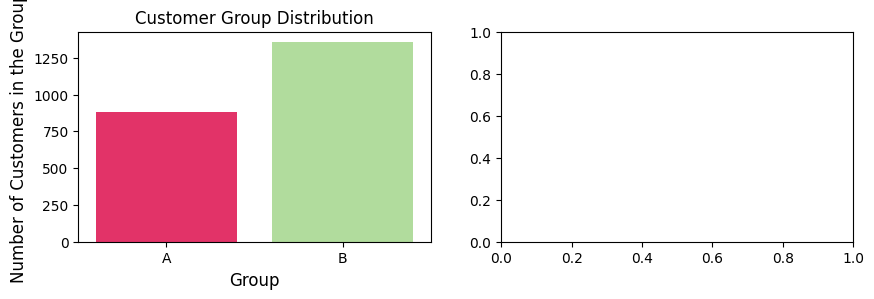

In [42]:
dataset = pd.read_csv('../static/Mall_Customers (1).csv')
process_dataset(dataset)